### Import statements

In [1]:
import random
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import numpy as np
import copy
import pickle

# DGL and pytorch 
import dgl
import dgl.function as fn 
import torch
import torch.nn.functional as F
import torch.nn as nn
from dgl.nn.pytorch import GraphConv
from dgl.nn.pytorch.explain import gnnexplainer

from collections import OrderedDict
import networkx as nx

In [2]:
# Setting seeds
seed_now = 98765 #15213#, 98119
random.seed(seed_now)
np.random.seed(seed_now)
dgl.random.seed(seed_now)
torch.manual_seed(seed_now)

## Set up dummy model

In [3]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size, bias=False)
        #self.conv2 = GraphConv(hidden_size, 1, bias=False)

    def forward(self, graph, feat,eweight=None):
        h = self.conv1.forward(graph, feat, edge_weight=eweight)
        #h1 = self.conv2.forward(graph, h, edge_weight=eweight)
        out = torch.sigmoid(h)
        return torch.cat((1-out,out), 1)

In [4]:
model = GCN(1, 1, 1)
params_gcn = OrderedDict([('conv1.weight', torch.tensor([[1]]))
#                           ,('conv1.bias', torch.tensor([1]))
                         ])

model.load_state_dict(params_gcn)

<All keys matched successfully>

# Test explainability

In [5]:
def repeat_explainability_xtimes(model,g,target_node=[1],n=4,score_thresh=0.8):
    feats = g.ndata['feature']
    with torch.no_grad():
        model.eval()
        output = model.forward(g, feats.float())
        #tmp = tmp.detach()
        output = output.detach()
        print(output)
        
    model_explain = gnnexplainer.GNNExplainer(model,num_hops=2,lr=0.05,num_epochs=1000)
    
    plt.figure(figsize=(25,25),edgecolor='g')
    nr = int(np.ceil(np.sqrt(n)))
    fig,ax = plt.subplots(nr,nr,figsize=(10,10))
    for i in range(0,n):
        new_center, sg, feat_mask, edge_mask = model_explain.explain_node(target_node, g, feats.float())
        print("Feature mask")
        print(feat_mask)
        print("Edge mask")
        print(edge_mask)
        sg.edata['weight'] = edge_mask
        gsub = dgl.to_networkx(sg,edge_attrs=['weight']) 
        edges = gsub.edges()
        weights = [gsub[u][v][0]['weight']*2+0.2 for u,v in edges]
        weight_labels = {e:str(w.item())[0:5] for e,w in zip(gsub.edges(),weights)}
    
        if i==0:
            pos = nx.spring_layout(gsub)
    
        ix = np.unravel_index(i,ax.shape)
        colormap = ['r' if k in target_node else 'g' for k in gsub.nodes()]
        plt.sca(ax[ix])
        labels = {node:node for node in g_nx.nodes()}
        nx.draw_networkx_nodes(g_nx,pos,ax=ax[ix],node_color=colormap)
        nx.draw_networkx_edges(g_nx,pos,ax=ax[ix],width=weights,connectionstyle="arc3,rad=0.3")
        nx.draw_networkx_labels(g_nx,pos,labels,font_size=16,font_color='k')

        #nx.draw_networkx_edge_labels(gsub, pos,ax=ax[ix], edge_labels=weight_labels)

    #plt.figure()
    #plt.plot(model_explain.loss_trajectory)
    

### Test graph 1

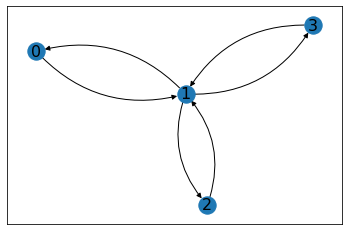

In [6]:
# Create dummy graph
src_list = [0,1,1]
dst_list = [1,2,3]
u = np.concatenate([src_list,dst_list])
v = np.concatenate([dst_list, src_list])
g = dgl.graph((u,v))
# Add self-loops for order nodes only
#g.add_edges(g.nodes(),g.nodes())
                    
g_nx = dgl.to_networkx(g) 
labels = {node:node for node in g_nx.nodes()}
pos = nx.spring_layout(g_nx)
nx.draw_networkx_nodes(g_nx,pos)
nx.draw_networkx_edges(g_nx,pos,connectionstyle="arc3,rad=0.3")
nx.draw_networkx_labels(g_nx,pos,labels,font_size=16,font_color='k')

# Create dummy features
feats = torch.tensor([[300],[-100],[-10],[-100]])
g.ndata['feature'] = feats

tensor([[1.0000e+00, 8.4333e-26],
        [0.0000e+00, 1.0000e+00],
        [1.0000e+00, 8.4333e-26],
        [1.0000e+00, 8.4333e-26]])
Pred label:
tensor([0, 1, 0, 0])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 530.36it/s]


Logits, explainer model:
tensor([[0.8714, 0.1286],
        [0.0213, 0.9787],
        [0.8714, 0.1286],
        [0.5001, 0.4999]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.3892, -1.1319],
        [-1.2823, -0.3249],
        [-0.3892, -1.1319],
        [-0.6931, -0.6932]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0331)
Edge mask
tensor([9.9985e-01, 9.9985e-01, 1.4740e-04, 9.9985e-01, 1.5393e-04, 9.9985e-01])
Pred label:
tensor([0, 1, 0, 0])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 553.57it/s]


Logits, explainer model:
tensor([[0.8028, 0.1972],
        [0.0146, 0.9854],
        [0.5001, 0.4999],
        [0.8028, 0.1972]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.4355, -1.0411],
        [-1.2920, -0.3212],
        [-0.6931, -0.6932],
        [-0.4355, -1.0411]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0243)
Edge mask
tensor([9.9984e-01, 1.5795e-04, 9.9985e-01, 9.9985e-01, 1.6398e-04, 2.1866e-04])
Pred label:
tensor([0, 1, 0, 0])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 547.56it/s]


Logits, explainer model:
tensor([[0.8714, 0.1286],
        [0.0213, 0.9787],
        [0.5001, 0.4999],
        [0.8714, 0.1286]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.3892, -1.1319],
        [-1.2823, -0.3249],
        [-0.6931, -0.6932],
        [-0.3892, -1.1319]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0331)
Edge mask
tensor([9.9986e-01, 1.4509e-04, 9.9985e-01, 9.9985e-01, 1.5921e-04, 9.9985e-01])
Pred label:
tensor([0, 1, 0, 0])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 542.76it/s]


Logits, explainer model:
tensor([[0.5001, 0.4999],
        [0.0146, 0.9854],
        [0.5001, 0.4999],
        [0.8028, 0.1972]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.6931, -0.6932],
        [-1.2920, -0.3212],
        [-0.6931, -0.6932],
        [-0.4355, -1.0411]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0243)
Edge mask
tensor([9.9986e-01, 1.5906e-04, 9.9985e-01, 1.5330e-04, 1.5947e-04, 1.5177e-04])
Pred label:
tensor([0, 1, 0, 0])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 585.34it/s]


Logits, explainer model:
tensor([[0.8795, 0.1205],
        [0.0224, 0.9776],
        [0.5001, 0.4999],
        [0.8795, 0.1205]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.3840, -1.1430],
        [-1.2807, -0.3255],
        [-0.6931, -0.6932],
        [-0.3840, -1.1430]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0344)
Edge mask
tensor([9.9986e-01, 1.5844e-04, 9.9985e-01, 9.9985e-01, 9.9985e-01, 9.9984e-01])
Pred label:
tensor([0, 1, 0, 0])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 526.39it/s]


Logits, explainer model:
tensor([[0.8087, 0.1913],
        [0.0151, 0.9849],
        [0.5001, 0.4999],
        [0.8087, 0.1913]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.4314, -1.0487],
        [-1.2913, -0.3215],
        [-0.6931, -0.6932],
        [-0.4314, -1.0487]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0250)
Edge mask
tensor([9.9975e-01, 1.5388e-04, 9.9985e-01, 9.9985e-01, 9.9986e-01, 1.3850e-04])
Pred label:
tensor([0, 1, 0, 0])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 597.58it/s]


Logits, explainer model:
tensor([[0.5001, 0.4999],
        [0.0224, 0.9776],
        [0.5001, 0.4999],
        [0.5001, 0.4999]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.6931, -0.6932],
        [-1.2807, -0.3255],
        [-0.6931, -0.6932],
        [-0.6931, -0.6932]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0344)
Edge mask
tensor([9.9986e-01, 1.5393e-04, 1.5459e-04, 1.5936e-04, 9.9985e-01, 9.9984e-01])
Pred label:
tensor([0, 1, 0, 0])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 595.40it/s]


Logits, explainer model:
tensor([[0.8713, 0.1287],
        [0.0213, 0.9787],
        [0.8713, 0.1287],
        [0.8713, 0.1287]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.3892, -1.1319],
        [-1.2823, -0.3249],
        [-0.3892, -1.1319],
        [-0.3892, -1.1319]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0331)
Edge mask
tensor([9.9988e-01, 9.9985e-01, 9.9985e-01, 9.9986e-01, 1.5576e-04, 9.9985e-01])
Pred label:
tensor([0, 1, 0, 0])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 575.43it/s]

Logits, explainer model:
tensor([[0.8714, 0.1286],
        [0.0213, 0.9787],
        [0.8714, 0.1286],
        [0.8714, 0.1286]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.3892, -1.1319],
        [-1.2823, -0.3249],
        [-0.3892, -1.1319],
        [-0.3892, -1.1319]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0331)
Edge mask
tensor([9.9985e-01, 9.9985e-01, 9.9985e-01, 9.9985e-01, 1.5572e-04, 9.9984e-01])


<Figure size 1800x1800 with 0 Axes>

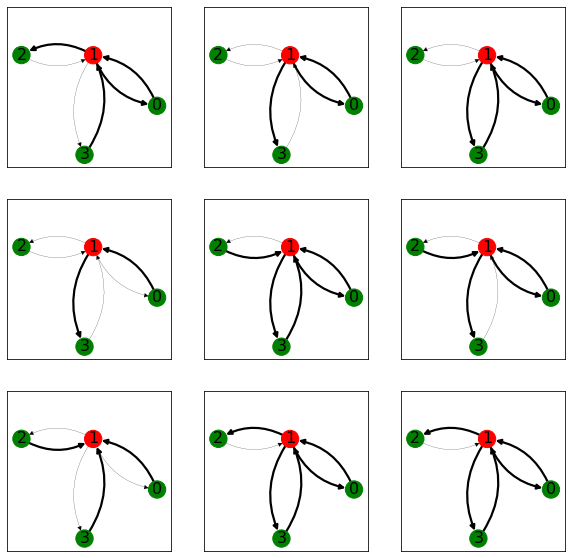

In [7]:
repeat_explainability_xtimes(model,g,n=9)

### Test graph 2: Test graph 1, different target node 

tensor([[1.0000e+00, 8.4333e-26],
        [0.0000e+00, 1.0000e+00],
        [1.0000e+00, 8.4333e-26],
        [1.0000e+00, 8.4333e-26]])
Pred label:
tensor([0, 1, 0, 0])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 578.01it/s]


Logits, explainer model:
tensor([[0.5001, 0.4999],
        [0.5781, 0.4219],
        [0.9593, 0.0407],
        [0.5001, 0.4999]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.6930, -0.6933],
        [-0.6181, -0.7743],
        [-0.3358, -1.2545],
        [-0.6930, -0.6933]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0548)
Edge mask
tensor([1.5710e-04, 9.9985e-01, 1.5462e-04, 1.5698e-04, 9.9985e-01, 1.5957e-04])
Pred label:
tensor([0, 1, 0, 0])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 591.29it/s]


Logits, explainer model:
tensor([[5.0012e-01, 4.9988e-01],
        [7.6175e-05, 9.9992e-01],
        [9.5932e-01, 4.0675e-02],
        [5.0012e-01, 4.9988e-01]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.6930, -0.6933],
        [-1.3132, -0.3133],
        [-0.3358, -1.2544],
        [-0.6930, -0.6933]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0548)
Edge mask
tensor([9.9985e-01, 9.9974e-01, 1.5445e-04, 1.5567e-04, 1.5849e-04, 1.2199e-04])
Pred label:
tensor([0, 1, 0, 0])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 587.61it/s]


Logits, explainer model:
tensor([[0.9593, 0.0407],
        [0.5781, 0.4219],
        [0.9593, 0.0407],
        [0.5001, 0.4999]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.3358, -1.2545],
        [-0.6181, -0.7743],
        [-0.3358, -1.2545],
        [-0.6930, -0.6933]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0548)
Edge mask
tensor([1.5814e-04, 9.9988e-01, 1.5622e-04, 9.9989e-01, 9.9985e-01, 1.5956e-04])
Pred label:
tensor([0, 1, 0, 0])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 595.26it/s]

Logits, explainer model:
tensor([[0.9593, 0.0407],
        [0.5781, 0.4219],
        [0.9593, 0.0407],
        [0.5001, 0.4999]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.3358, -1.2545],
        [-0.6181, -0.7743],
        [-0.3358, -1.2545],
        [-0.6930, -0.6933]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0548)
Edge mask
tensor([1.5877e-04, 9.9985e-01, 1.5953e-04, 9.9985e-01, 9.9985e-01, 1.5891e-04])


<Figure size 1800x1800 with 0 Axes>

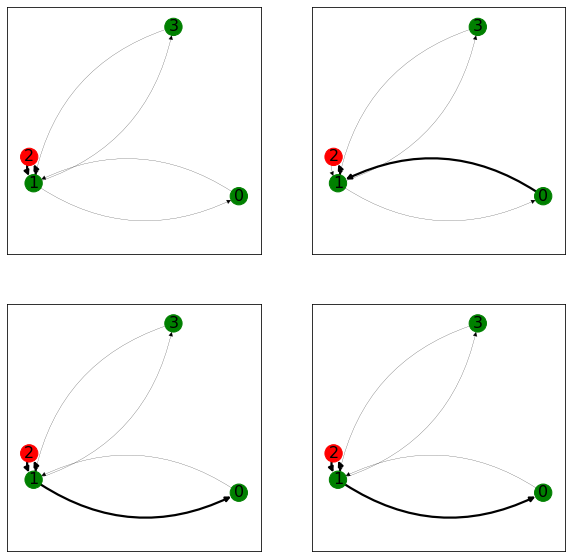

In [8]:
repeat_explainability_xtimes(model,g,target_node=[2])

### Test graph 3: Two pathways

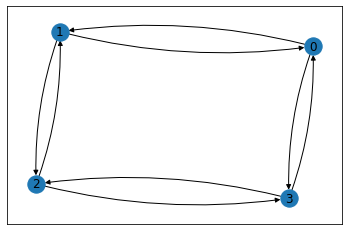

In [9]:
# Create dummy graph
src_list = [0,0,1,3]
dst_list = [1,3,2,2]
u = np.concatenate([src_list,dst_list])
v = np.concatenate([dst_list, src_list])
g = dgl.graph((u,v))
    
# Add self-loops for order nodes only
#g.add_edges(g.nodes(),g.nodes())
                    
g_nx = dgl.to_networkx(g) 
pos = nx.spring_layout(g_nx)
nx.draw_networkx_nodes(g_nx,pos)
nx.draw_networkx_labels(g_nx,pos)
nx.draw_networkx_edges(g_nx,pos,connectionstyle="arc3,rad=0.1")


# Create dummy features
feats = torch.tensor([[0],[10],[50],[-100]])
g.ndata['feature'] = feats

tensor([[1.0000e+00, 2.8625e-20],
        [0.0000e+00, 1.0000e+00],
        [1.0000e+00, 2.8625e-20],
        [0.0000e+00, 1.0000e+00]])
Pred label:
tensor([0, 1, 0, 1])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 586.35it/s]


Logits, explainer model:
tensor([[0.5001, 0.4999],
        [0.4999, 0.5001],
        [0.9535, 0.0465],
        [0.1808, 0.8192]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.6930, -0.6933],
        [-0.6932, -0.6931],
        [-0.3391, -1.2462],
        [-1.0624, -0.4241]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0604)
Edge mask
tensor([9.9986e-01, 9.9985e-01, 1.5947e-04, 1.5862e-04, 1.5949e-04, 9.9985e-01,
        9.9986e-01, 1.5999e-04])
Pred label:
tensor([0, 1, 0, 1])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 534.75it/s]


Logits, explainer model:
tensor([[0.5001, 0.4999],
        [0.1808, 0.8192],
        [0.9535, 0.0465],
        [0.1808, 0.8192]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.6930, -0.6933],
        [-1.0624, -0.4241],
        [-0.3391, -1.2462],
        [-1.0624, -0.4241]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0604)
Edge mask
tensor([9.9985e-01, 9.9985e-01, 1.5476e-04, 1.5500e-04, 9.9985e-01, 9.9985e-01,
        9.9986e-01, 1.5696e-04])
Pred label:
tensor([0, 1, 0, 1])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 550.52it/s]


Logits, explainer model:
tensor([[0.4198, 0.5802],
        [0.5000, 0.5000],
        [0.9488, 0.0512],
        [0.1650, 0.8350]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.7766, -0.6161],
        [-0.6932, -0.6931],
        [-0.3419, -1.2394],
        [-1.0832, -0.4132]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0649)
Edge mask
tensor([1.6032e-04, 1.5566e-04, 9.9985e-01, 9.9985e-01, 1.1948e-04, 9.9985e-01,
        9.9986e-01, 1.5041e-04])
Pred label:
tensor([0, 1, 0, 1])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 546.38it/s]


Logits, explainer model:
tensor([[0.9488, 0.0512],
        [0.1650, 0.8350],
        [0.9488, 0.0512],
        [0.4999, 0.5001]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.3419, -1.2394],
        [-1.0832, -0.4132],
        [-0.3419, -1.2394],
        [-0.6932, -0.6931]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0649)
Edge mask
tensor([1.5566e-04, 9.9985e-01, 9.9986e-01, 9.9986e-01, 9.9985e-01, 1.5842e-04,
        9.9975e-01, 9.9985e-01])
Pred label:
tensor([0, 1, 0, 1])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 547.63it/s]


Logits, explainer model:
tensor([[0.9535, 0.0465],
        [0.1809, 0.8191],
        [0.9535, 0.0465],
        [0.4999, 0.5001]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.3391, -1.2462],
        [-1.0624, -0.4241],
        [-0.3391, -1.2462],
        [-0.6932, -0.6931]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0604)
Edge mask
tensor([1.6056e-04, 1.6052e-04, 1.5901e-04, 1.5969e-04, 9.9985e-01, 1.6054e-04,
        9.9989e-01, 9.9985e-01])
Pred label:
tensor([0, 1, 0, 1])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 592.71it/s]


Logits, explainer model:
tensor([[0.9624, 0.0376],
        [0.1650, 0.8350],
        [0.9488, 0.0512],
        [0.1650, 0.8350]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.3340, -1.2589],
        [-1.0832, -0.4132],
        [-0.3419, -1.2394],
        [-1.0832, -0.4132]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0649)
Edge mask
tensor([1.5938e-04, 1.6020e-04, 9.9985e-01, 1.5976e-04, 9.9985e-01, 9.9985e-01,
        9.9985e-01, 9.9985e-01])
Pred label:
tensor([0, 1, 0, 1])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 593.23it/s]


Logits, explainer model:
tensor([[0.9488, 0.0512],
        [0.1650, 0.8350],
        [0.9488, 0.0512],
        [0.1650, 0.8350]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.3419, -1.2394],
        [-1.0832, -0.4132],
        [-0.3419, -1.2394],
        [-1.0832, -0.4132]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0649)
Edge mask
tensor([0.9998, 0.9998, 0.9999, 0.9998, 0.9999, 0.9999, 0.9999, 0.9999])
Pred label:
tensor([0, 1, 0, 1])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 603.94it/s]


Logits, explainer model:
tensor([[0.9624, 0.0376],
        [0.4999, 0.5001],
        [0.9487, 0.0513],
        [0.1650, 0.8350]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.3340, -1.2589],
        [-0.6932, -0.6931],
        [-0.3419, -1.2394],
        [-1.0833, -0.4132]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0649)
Edge mask
tensor([1.3804e-04, 9.9985e-01, 9.9986e-01, 1.5705e-04, 1.5748e-04, 9.9986e-01,
        9.9974e-01, 9.9985e-01])
Pred label:
tensor([0, 1, 0, 1])


Explain node {node_id}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 590.80it/s]

Logits, explainer model:
tensor([[0.5001, 0.4999],
        [0.1808, 0.8192],
        [0.9535, 0.0465],
        [0.4999, 0.5001]], grad_fn=<CatBackward>)
log probs, explainer model:
tensor([[-0.6930, -0.6933],
        [-1.0624, -0.4241],
        [-0.3391, -1.2462],
        [-0.6932, -0.6931]], grad_fn=<LogSoftmaxBackward>)
Feature mask
tensor(0.0604)
Edge mask
tensor([9.9985e-01, 9.9985e-01, 1.6654e-04, 1.6017e-04, 9.9986e-01, 1.5618e-04,
        9.9977e-01, 1.5720e-04])


<Figure size 1800x1800 with 0 Axes>

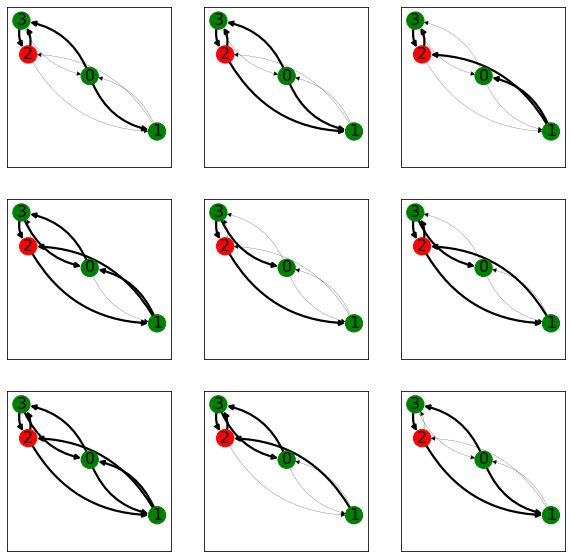

In [10]:
repeat_explainability_xtimes(model,g,target_node=[2],n=9)

### Test graph 4: Barbell graph

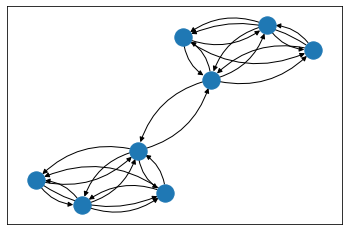

In [11]:
# Create dummy graph
src_list = [1,2,3,2,3,3,5,5,6,7,6,7,7]
dst_list = [0,0,0,1,1,2,3,4,4,4,5,5,6]
u = np.concatenate([src_list,dst_list])
v = np.concatenate([dst_list, src_list])
g = dgl.graph((u,v))
    
# Add self-loops for order nodes only
#g.add_edges(g.nodes(),g.nodes())
                    
g_nx = dgl.to_networkx(g) 
pos = nx.spring_layout(g_nx)
nx.draw_networkx_nodes(g_nx,pos)
nx.draw_networkx_edges(g_nx,pos,connectionstyle="arc3,rad=0.3")


# Create dummy features
feats = torch.tensor([[1],[0],[0],[0],[0],[0],[0],[0]])
g.ndata['feature'] = feats